Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/using-mlflow/train-local/train-local.png)

## Use MLflow with Azure Machine Learning for Local Training Run

This example shows you how to use mlflow tracking APIs together with Azure Machine Learning services for storing your metrics and artifacts, from local Notebook run. You'll learn how to:

 1. Set up MLflow tracking URI so as to use Azure ML
 2. Create experiment
 3. Train a model on your local computer while logging metrics and artifacts
 4. View your experiment within your Azure ML Workspace in Azure Portal.

## Prerequisites and Set-up

Make sure you have completed the [Configuration](../../../configuration.ipnyb) notebook to set up your Azure Machine Learning workspace and ensure other common prerequisites are met.

Install azureml-mlflow package before running this notebook. Note that mlflow itself gets installed as dependency if you haven't installed it yet.

```
pip install azureml-mlflow
```

This example also uses scikit-learn and matplotlib packages. Install them:
```
pip install scikit-learn matplotlib
```

Then, import necessary packages

In [4]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.38.0


## Set tracking URI

Set the MLflow tracking URI to point to your Azure ML Workspace. The subsequent logging calls from MLflow APIs will go to Azure ML services and will be tracked under your Workspace.

In [5]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

## Create Experiment

In both MLflow and Azure ML, training runs are grouped into experiments. Let's create one for our experimentation.

In [6]:
experiment_name = "LocalTrain-with-mlflow-sample"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='', experiment_id='9d84ced3-5717-4e6f-800f-912d73708c5f', lifecycle_stage='active', name='LocalTrain-with-mlflow-sample', tags={}>

## Create training and test data set

This example uses diabetes dataset to build a simple regression model. Let's load the dataset and split it into training and test sets.

In [7]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")

Data contains 353 training samples and 89 test samples


## Train while logging metrics and artifacts

Next, start a mlflow run to train a scikit-learn regression model. Note that the training script has been instrumented using MLflow to:
 * Log model hyperparameter alpha value
 * Log mean squared error against test set
 * Save the scikit-learn based regression model produced by training
 * Save an image that shows actuals vs predictions against test set.
 
These metrics and artifacts have been recorded to your Azure ML Workspace; in the next step you'll learn how to view them.

Mean Squared Error is 3424.900315896018


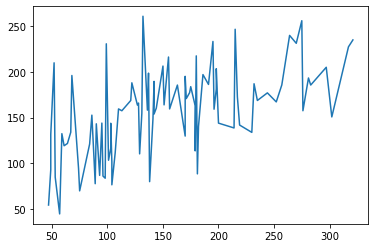

In [8]:
# Create a run object in the experiment
model_save_path = "model"

with mlflow.start_run() as run:
    # Log the algorithm parameter alpha to the run
    mlflow.log_metric('alpha', 0.03)
    # Create, fit, and test the scikit-learn Ridge regression model
    regression_model = Ridge(alpha=0.03)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # Log mean squared error
    print('Mean Squared Error is', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    # Save the model to the outputs directory for capture
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    # Plot actuals vs predictions and save the plot within the run
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("actuals_vs_predictions.png")
    mlflow.log_artifact("actuals_vs_predictions.png") 

You can open the report page for your experiment and runs within it from Azure Portal.

Select one of the runs to view the metrics, and the plot you saved. The saved scikit-learn model appears under **outputs** tab.

In [9]:
ws.experiments[experiment_name]

Name,Workspace,Report Page,Docs Page
LocalTrain-with-mlflow-sample,aml-workspace,Link to Azure Machine Learning studio,Link to Documentation


### Next steps

Try out these notebooks to learn more about MLflow-Azure Machine Learning integration:

 * [Train a model using remote compute on Azure Cloud](../train-on-remote/train-on-remote.ipynb)
 * [Deploy the model as a web service](../deploy-model/deploy-model.ipynb)